In [1]:
import pandas as pd
from datetime import datetime
from lib_descriptive import plot_histograms
from lib_data import fetch_data, fetch_spot_prices
from lib_predictive import preprocess_data, split_data, normalize_data, reshape_data_LSTM, train_lstm_model, evaluate_model, predict_future, load_model

2025-01-02 18:13:39.829664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735838019.850518   16457 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735838019.856733   16457 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 18:13:39.885759: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator



In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# asof = datetime.combine(datetime.now(), time.min)
asof = datetime(2024, 12, 1)
start_date = datetime(2020, 1, 1)
API_KEY = 'YOUR_DMI_API_KEY'
STATION_ID = '06030'  # Aalborg weather station
LAT, LON = 57.048, 9.9187 # Coordinates for Aalborg

In [4]:
historical_spot_prices = fetch_spot_prices(start_date, asof)
historical_wind_data = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", start_date, asof, 'wind_speed', STATION_ID, API_KEY, historical=True)
historical_temp_data = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", start_date, asof, 'temp_dry', STATION_ID, API_KEY, historical=True)

In [5]:
df = preprocess_data(historical_spot_prices, historical_wind_data, historical_temp_data)

In [6]:
features = ['day_of_year','weekday' ,'hour' ,'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'epoch' ,'wind_speed', 'temperature']
target = 'PriceEUR'

X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, features, target)

In [19]:

X_train, X_val, X_test, y_train, y_val, y_test, scaler_y = normalize_data(X_train, X_val, X_test, y_train, y_val, y_test)



ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

In [8]:
print(X_train)

[[0.00000000e+00 3.33333333e-01 0.00000000e+00 ... 0.00000000e+00
  2.92743953e-01 3.65887687e-01]
 [0.00000000e+00 3.33333333e-01 4.34782609e-02 ... 3.30250991e-05
  3.17764804e-01 3.91349843e-01]
 [0.00000000e+00 3.33333333e-01 8.69565217e-02 ... 6.60501981e-05
  3.26939116e-01 3.96232996e-01]
 ...
 [4.52054795e-01 5.00000000e-01 6.08695652e-01 ... 9.99933950e-01
  1.71809842e-01 7.97349145e-01]
 [4.52054795e-01 5.00000000e-01 6.52173913e-01 ... 9.99966975e-01
  1.84320267e-01 7.87582839e-01]
 [4.52054795e-01 5.00000000e-01 6.95652174e-01 ... 1.00000000e+00
  1.80150125e-01 7.77118940e-01]]


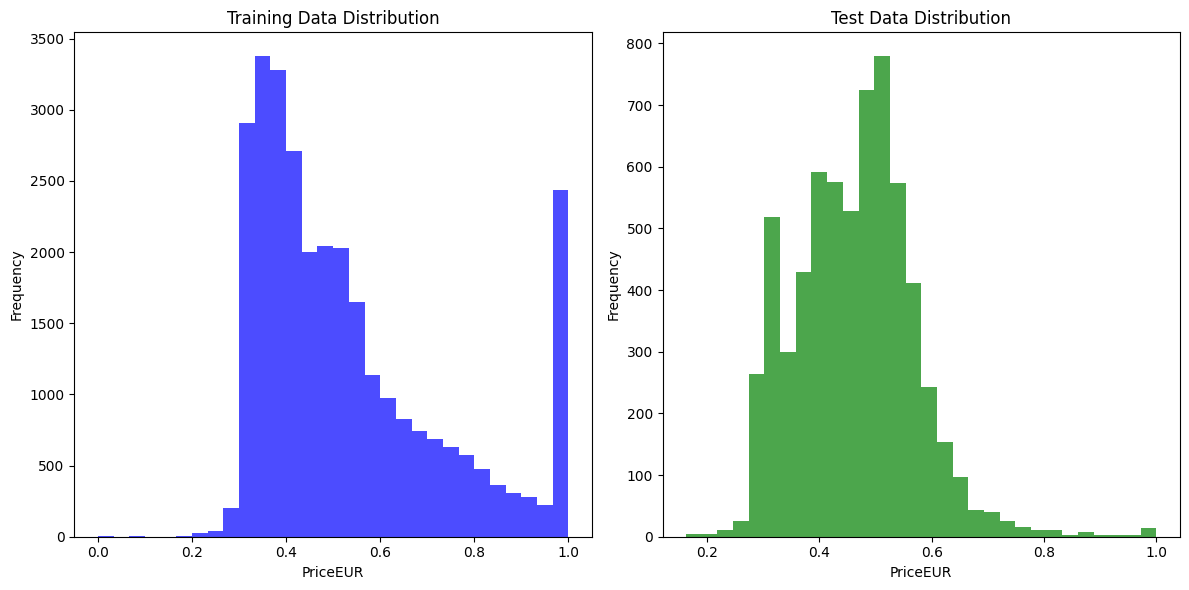

In [9]:
plot_histograms(y_train, y_test)

In [10]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(29920, 10) (6411, 10) (6412, 10)
(29920, 1) (6411, 1) (6412, 1)


In [11]:
# Reshape data for LSTM
X_train, X_val, X_test = reshape_data_LSTM(X_train, X_val, X_test)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

# generator_training = TimeseriesGenerator(X_train, y_train, length=24, batch_size=32)
# generator_test = TimeseriesGenerator(X_test, y_test, length=24, batch_size=32)
# generator_validation = TimeseriesGenerator(X_val, y_val, length=24, batch_size=32)

(29920, 1, 10) (6411, 1, 10) (6412, 1, 10)
(29920, 1) (6411, 1) (6412, 1)


In [12]:
# Train LSTM model
model, history = train_lstm_model(X_train, y_train, X_val, y_val)

I0000 00:00:1735838027.797720   16457 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4093 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/20


I0000 00:00:1735838031.088847   16529 service.cc:148] XLA service 0x7efe6000afe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735838031.089408   16529 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti with Max-Q Design, Compute Capability 7.5
2025-01-02 18:13:51.176476: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735838031.644157   16529 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1735838034.528141   16529 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


234/234 - 13s - 55ms/step - loss: 0.0208 - val_loss: 0.0063
Epoch 2/20
234/234 - 2s - 7ms/step - loss: 0.0120 - val_loss: 0.0057
Epoch 3/20
234/234 - 2s - 7ms/step - loss: 0.0112 - val_loss: 0.0055
Epoch 4/20
234/234 - 2s - 8ms/step - loss: 0.0111 - val_loss: 0.0055
Epoch 5/20
234/234 - 2s - 7ms/step - loss: 0.0113 - val_loss: 0.0056
Epoch 6/20
234/234 - 2s - 8ms/step - loss: 0.0117 - val_loss: 0.0058
Epoch 7/20
234/234 - 2s - 8ms/step - loss: 0.0122 - val_loss: 0.0065
Epoch 8/20
234/234 - 2s - 8ms/step - loss: 0.0123 - val_loss: 0.0053
Epoch 9/20
234/234 - 2s - 9ms/step - loss: 0.0112 - val_loss: 0.0070
Epoch 10/20
234/234 - 2s - 8ms/step - loss: 0.0134 - val_loss: 0.0080
Epoch 11/20
234/234 - 2s - 8ms/step - loss: 0.0142 - val_loss: 0.0089
Epoch 12/20
234/234 - 2s - 8ms/step - loss: 0.0149 - val_loss: 0.0098
Epoch 13/20
234/234 - 2s - 8ms/step - loss: 0.0154 - val_loss: 0.0105
Epoch 14/20
234/234 - 2s - 7ms/step - loss: 0.0158 - val_loss: 0.0112
Epoch 15/20
234/234 - 2s - 8ms/step - 

201/201 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Mean Absolute Error: 0.15 EUR


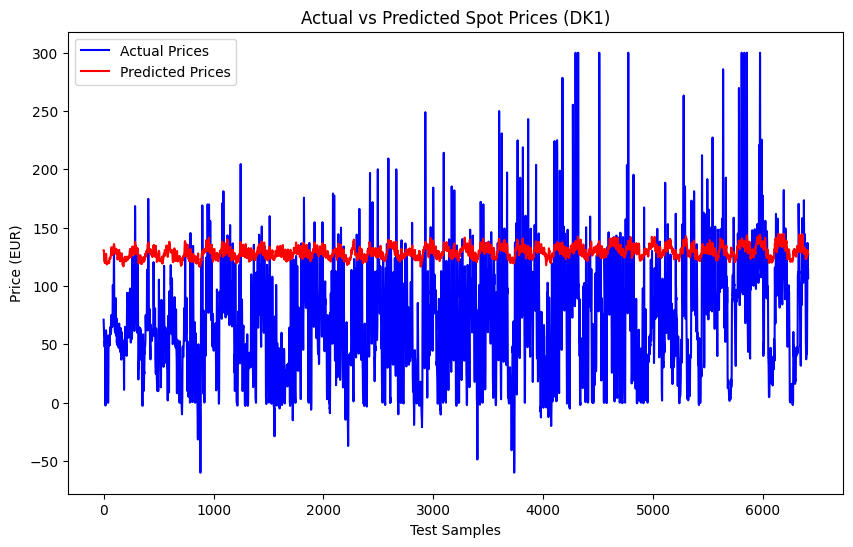

In [13]:
from lib_descriptive import plot_predictions


predictions = evaluate_model(model, X_test, y_test)
scaled_predictions = scaler_y.inverse_transform(predictions)
scaled_y_test = scaler_y.inverse_transform(y_test)
plot_predictions(scaled_y_test, scaled_predictions)

In [14]:
# Load the model for future predictions
import lib_predictive
import lib_descriptive
import lib_prescriptive
from keras.models import load_model

model = load_model('lstm_model.keras')

201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


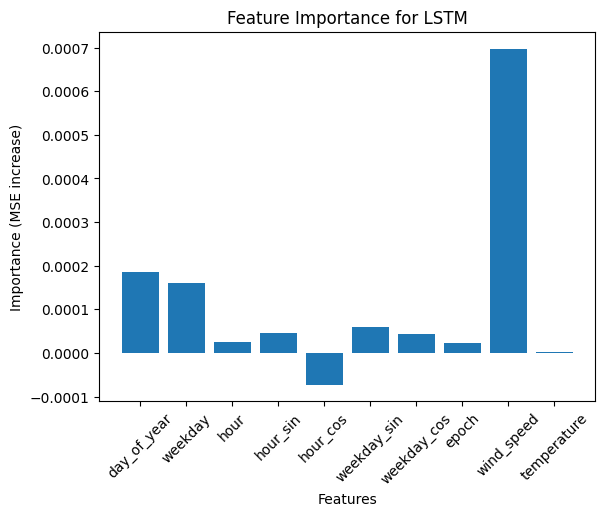

In [15]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
baseline_mse = mean_squared_error(y_test, model.predict(X_test))

def permutation_importance(model, X_test, y_test, baseline_mse):
    importances = []
    for feature in range(X_test.shape[2]):
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, :, feature])  # Shuffle one feature at a time
        mse = mean_squared_error(y_test, model.predict(X_permuted))
        importances.append(mse - baseline_mse)
    return importances

# Compute feature importances
importances = permutation_importance(model, X_test, y_test, baseline_mse)

# Assuming feature names are available
feature_names = features
plt.bar(feature_names, importances)
plt.xlabel('Features')
plt.ylabel('Importance (MSE increase)')
plt.title('Feature Importance for LSTM')
plt.xticks(rotation=45)
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


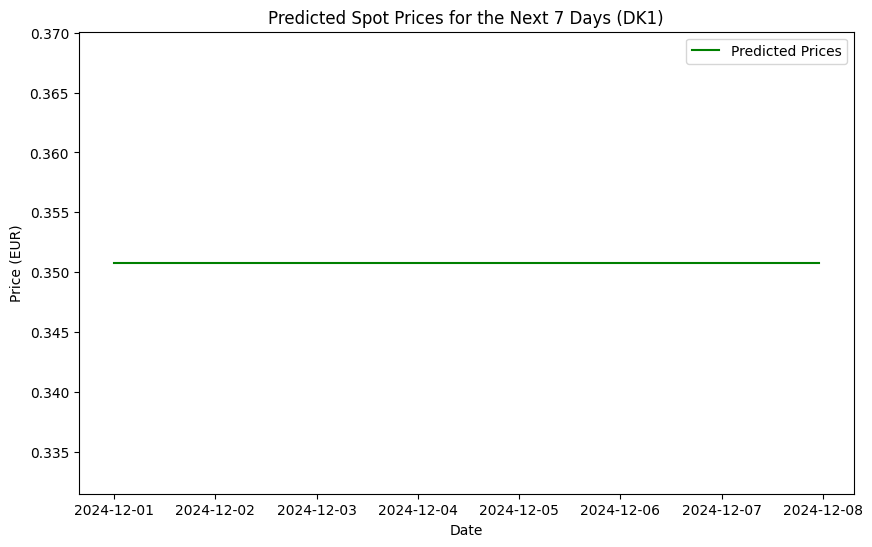

In [16]:

future_df = predict_future(model, asof)
# rescale priceEUR to original scale
future_df['PriceEUR'] = scaler_y.inverse_transform(future_df['PriceEUR'].values.reshape(-1, 1))


In [17]:
print(future_df)
print(predictions)

      PriceEUR              HourDK
0    20.867136 2024-12-01 00:00:00
1    20.867136 2024-12-01 01:00:00
2    20.867136 2024-12-01 02:00:00
3    20.867136 2024-12-01 03:00:00
4    20.867136 2024-12-01 04:00:00
..         ...                 ...
163  20.867136 2024-12-07 19:00:00
164  20.867136 2024-12-07 20:00:00
165  20.867136 2024-12-07 21:00:00
166  20.867136 2024-12-07 22:00:00
167  20.867136 2024-12-07 23:00:00

[168 rows x 2 columns]
[[0.60606784]
 [0.60472023]
 [0.6035803 ]
 ...
 [0.5982307 ]
 [0.5996922 ]
 [0.5988175 ]]


In [18]:
future_df

,PriceEUR,HourDK
0,20.867136,2024-12-01 00:00:00
1,20.867136,2024-12-01 01:00:00
2,20.867136,2024-12-01 02:00:00
3,20.867136,2024-12-01 03:00:00
4,20.867136,2024-12-01 04:00:00
...,...,...
163,20.867136,2024-12-07 19:00:00
164,20.867136,2024-12-07 20:00:00
165,20.867136,2024-12-07 21:00:00
166,20.867136,2024-12-07 22:00:00
